In [38]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Image Directory
img_dir = "../input/psl-data/PSL DATA SET"

# Data Groups
grps = ["train", "test"]

# Class Labels
class_names = os.listdir(img_dir)

# Initializing a Dataframe to store paths and labels
column_names = ["grp","path", "label", "label_int", "filename"]
data = pd.DataFrame(columns = column_names)

In [3]:
# For label
for path in os.listdir(img_dir):
    if not path.startswith('.'):
        files = os.listdir(img_dir +'/'+ path)
        for f in files:
            if (f.endswith('.png') or f.endswith('.jpeg') or f.endswith('.jpg')):
                for orientation in [0, 90, 180, 270]:
                    data_append = {"path": img_dir +'/'+ path +'/'+ f,
                                "label": path,
                                "label_int": class_names.index(path),
                                "filename": f}
                    data = data.append(data_append, ignore_index = True)

# Printing Useful information

print("Data Shape: ", data.shape)
print("Labels: ", data.label.unique(), data.label_int.unique())

print("Dataset:")
data.head(3)

Data Shape:  (6036, 5)
Labels:  ['Dhuaad ض' 'aRay ڑ' 'Laam ل' 'Pay پ' 'Daal  د' 'Djay ژ' 'Jeem ج' 'Kaaf ک'
 'Dhaal ذ' 'Thay ث' 'hey ح' 'Sheen \u200e\u200eش' 'Daal ڈ' 'Vao و'
 'Noon ن' 'Aliph ا' 'Quaaf ق' 'Meem م' 'Suaad ص' 'Ain ع' 'Seen س'
 'Ghain غ' 'Bari yeh ے' 'Zay ز' 'Chhoti yeh ی' 'Ray ر' 'Gaaf گ' 'Fay ف'
 'Toay_n ط' 'Hay ہ' 'Tay ت' 'Tey ٹ' 'Zoay_n ظ' 'Bay ب' 'Khay خ'
 'Hamza \u200d\u200cء' 'Chay چ'] [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36]
Dataset:


,grp,path,label,label_int,filename
0,NaN,../input/psl-data/PSL DATA SET/Dhuaad ض/T_34.png,Dhuaad ض,0,T_34.png
1,NaN,../input/psl-data/PSL DATA SET/Dhuaad ض/T_34.png,Dhuaad ض,0,T_34.png
2,NaN,../input/psl-data/PSL DATA SET/Dhuaad ض/T_34.png,Dhuaad ض,0,T_34.png


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36],
 [Text(0, 0, 'Dhuaad ض'),
  Text(1, 0, 'aRay ڑ'),
  Text(2, 0, 'Laam ل'),
  Text(3, 0, 'Pay پ'),
  Text(4, 0, 'Daal  د'),
  Text(5, 0, 'Djay ژ'),
  Text(6, 0, 'Jeem ج'),
  Text(7, 0, 'Kaaf ک'),
  Text(8, 0, 'Dhaal ذ'),
  Text(9, 0, 'Thay ث'),
  Text(10, 0, 'hey ح'),
  Text(11, 0, 'Sheen \u200e\u200eش'),
  Text(12, 0, 'Daal ڈ'),
  Text(13, 0, 'Vao و'),
  Text(14, 0, 'Noon ن'),
  Text(15, 0, 'Aliph ا'),
  Text(16, 0, 'Quaaf ق'),
  Text(17, 0, 'Meem م'),
  Text(18, 0, 'Suaad ص'),
  Text(19, 0, 'Ain ع'),
  Text(20, 0, 'Seen س'),
  Text(21, 0, 'Ghain غ'),
  Text(22, 0, 'Bari yeh ے'),
  Text(23, 0, 'Zay ز'),
  Text(24, 0, 'Chhoti yeh ی'),
  Text(25, 0, 'Ray ر'),
  Text(26, 0, 'Gaaf گ'),
  Text(27, 0, 'Fay ف'),
  Text(28, 0, 'Toay_n ط'),
  Text(29, 0, 'Hay ہ'),
  Text(30, 0, 'Tay ت')

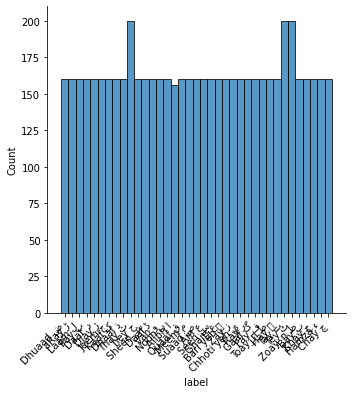

In [4]:
ax = sns.displot(data=data, x='label')
plt.xticks(rotation=45, horizontalalignment='right')

In [5]:
img_width = 32
img_height = 32
dim = (img_width, img_height)

# Initializing images column
data['img_read'] = np.nan
data['img_read'] = data['img_read'].astype("object")

# Iterating on all rows and reading image data
for index, row in tqdm(data.iterrows(), total=data.shape[0]):
        img = cv2.imread(row.path, 0)
        img = cv2.resize(img, dim)
        data.at[index, 'img_read'] = img

100%|██████████| 6036/6036 [01:05<00:00, 92.85it/s] 


In [6]:
X = np.stack(data.img_read.to_list())
Y = data.label_int.to_list()

In [7]:
X = np.expand_dims(X, axis=-1)

In [8]:
X.shape

(6036, 32, 32, 1)

In [9]:
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
Y=lb.fit_transform(Y)

In [10]:
Y.shape

(6036, 37)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, stratify = Y, random_state=69)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, stratify = y_train, random_state=69)

In [13]:
X_train.shape

(4888, 32, 32, 1)

In [14]:
X_test.shape

(604, 32, 32, 1)

In [15]:
X_val.shape

(544, 32, 32, 1)

In [16]:
datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range = 0,
                             height_shift_range=0.2,
                             width_shift_range=0.2,
                             shear_range=0,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

In [17]:
K.clear_session()

model=Sequential()
model.add(Conv2D(128, kernel_size=(5,5), strides=1, padding='same',activation='relu',input_shape=(28,28, 1)))
model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
model.add(Conv2D(64, kernel_size=(2,2), strides=1, activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
model.add(Conv2D(32, kernel_size=(2,2), strides=1, activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
model.add(Flatten())
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=37,activation='softmax'))
model.summary()

2022-01-04 21:45:03.956155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          8224      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

2022-01-04 21:45:04.073473: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 21:45:04.074231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 21:45:04.075639: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-04 21:45:04.077175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [18]:
model.compile(optimizer=Adam(learning_rate = 0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
EPOCH = 35
BATCH_SIZE = 64

In [20]:
history =model.fit(datagen.flow(X_train,y_train,batch_size=BATCH_SIZE),
          epochs = EPOCH,
          validation_data=(X_val / 255.0, y_val),
          shuffle=1)

Epoch 1/35


2022-01-04 21:45:06.997092: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-04 21:45:08.513905: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


77/77 [==============================] - 9s 23ms/step - loss: 3.4424 - accuracy: 0.0700 - val_loss: 2.4196 - val_accuracy: 0.2500
Epoch 2/35
77/77 [==============================] - 2s 24ms/step - loss: 2.4045 - accuracy: 0.2758 - val_loss: 1.5306 - val_accuracy: 0.5478
Epoch 3/35
77/77 [==============================] - 2s 20ms/step - loss: 1.9024 - accuracy: 0.4092 - val_loss: 0.9742 - val_accuracy: 0.7537
Epoch 4/35
77/77 [==============================] - 2s 20ms/step - loss: 1.5526 - accuracy: 0.4986 - val_loss: 0.8776 - val_accuracy: 0.6985
Epoch 5/35
77/77 [==============================] - 2s 20ms/step - loss: 1.3170 - accuracy: 0.5732 - val_loss: 0.6648 - val_accuracy: 0.7978
Epoch 6/35
77/77 [==============================] - 2s 20ms/step - loss: 1.1091 - accuracy: 0.6418 - val_loss: 0.5369 - val_accuracy: 0.8419
Epoch 7/35
77/77 [==============================] - 2s 20ms/step - loss: 0.9626 - accuracy: 0.6886 - val_loss: 0.3445 - val_accuracy: 0.9099
Epoch 8/35
77/77 [======

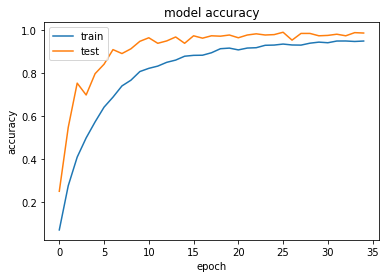

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

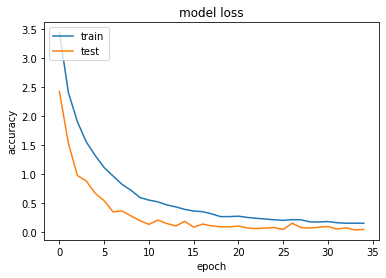

In [22]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
y_pred = model.predict(X_test)

In [24]:
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.70      1.00      0.82        16
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        16
           5       1.00      0.69      0.81        16
           6       1.00      0.88      0.93        16
           7       1.00      0.62      0.77        16
           8       1.00      0.69      0.81        16
           9       0.56      1.00      0.71        20
          10       0.91      0.62      0.74        16
          11       1.00      0.88      0.93        16
          12       1.00      0.94      0.97        16
          13       1.00      0.06      0.12        16
          14       1.00      0.38      0.55        16
          15       1.00      1.00      1.00        16
          16       1.00      1.00      1.00        16
          17       0.62    

<AxesSubplot:>

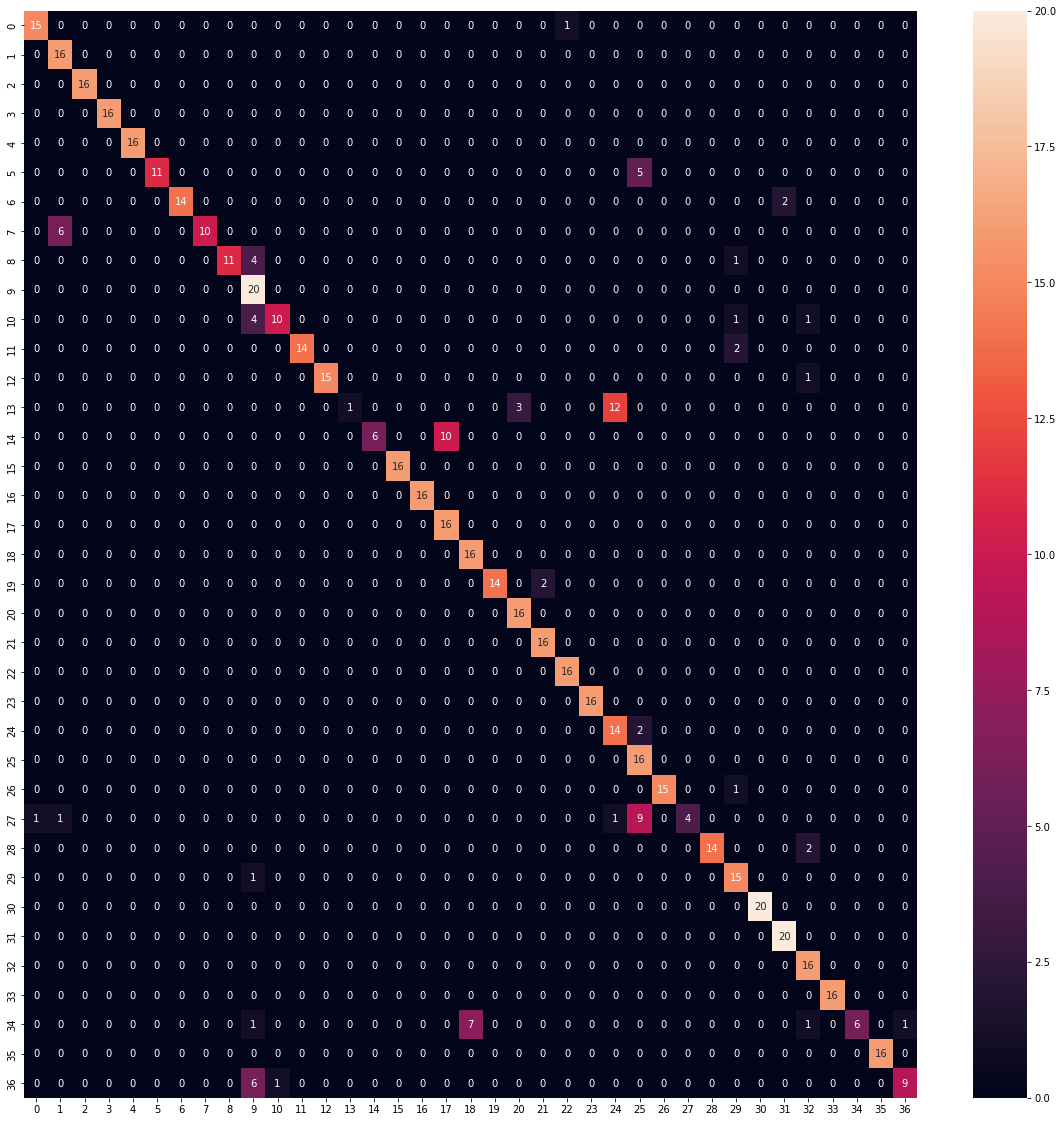

In [26]:
plt.figure(figsize = (20,20))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)

In [36]:
model.save("my_h5_model.h5")

In [40]:
reconstructed_model = load_model("my_h5_model.h5")

In [41]:
y_pred = reconstructed_model.predict(X_test)

In [42]:
y_pred=np.argmax(y_pred, axis=1)

In [43]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        16
           1       0.70      1.00      0.82        16
           2       1.00      1.00      1.00        16
           3       1.00      1.00      1.00        16
           4       1.00      1.00      1.00        16
           5       1.00      0.69      0.81        16
           6       1.00      0.88      0.93        16
           7       1.00      0.62      0.77        16
           8       1.00      0.69      0.81        16
           9       0.56      1.00      0.71        20
          10       0.91      0.62      0.74        16
          11       1.00      0.88      0.93        16
          12       1.00      0.94      0.97        16
          13       1.00      0.06      0.12        16
          14       1.00      0.38      0.55        16
          15       1.00      1.00      1.00        16
          16       1.00      1.00      1.00        16
          17       0.62    

<AxesSubplot:>

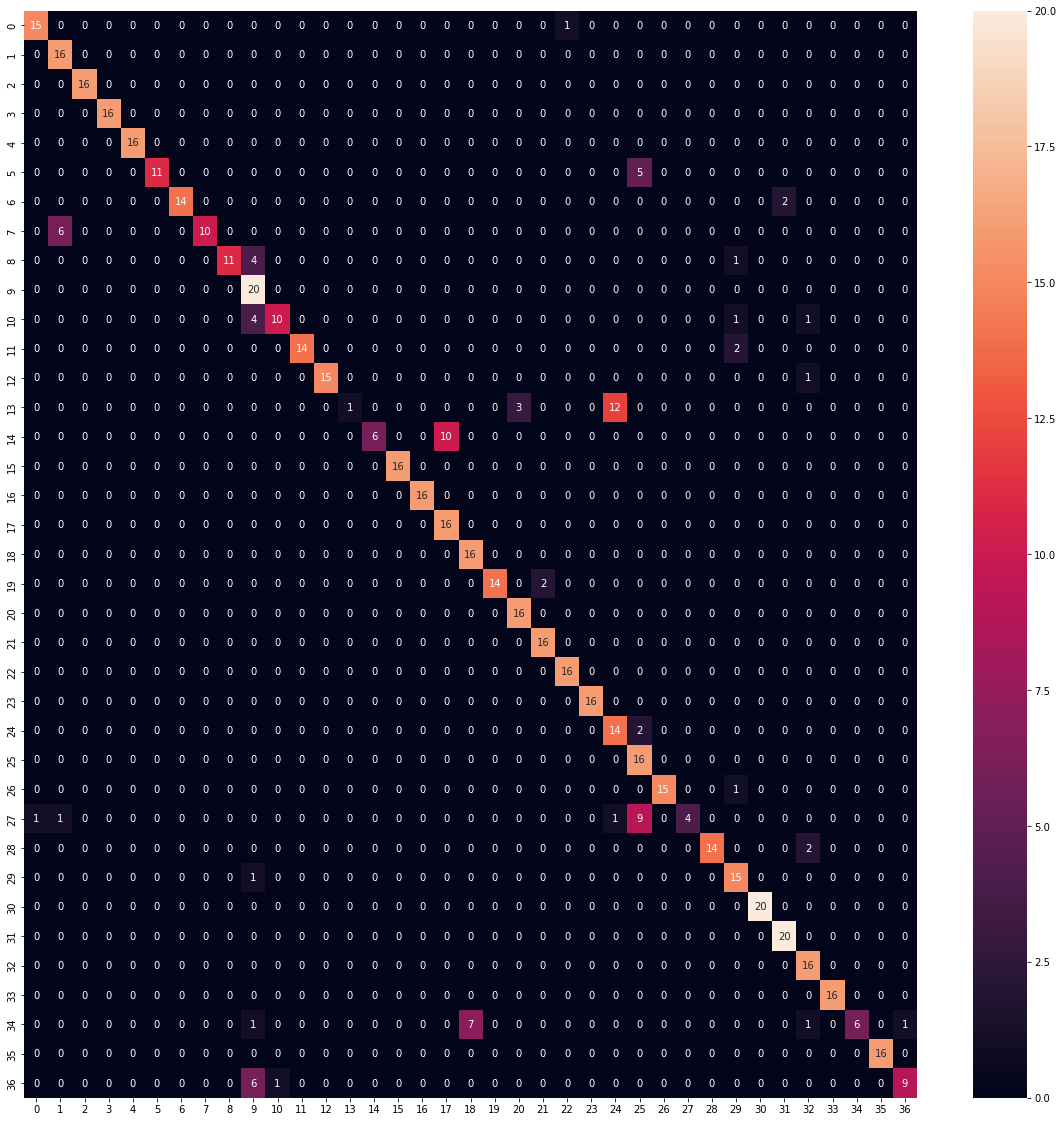

In [44]:
plt.figure(figsize = (20,20))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)